# 21點樸克牌(Blackjack)的Value Iteration值循環

In [1]:
# 匯入zipfile模組，用來處理.zip壓縮檔案
import zipfile

# 使用with敘述開啟lib.zip壓縮檔案，確保使用完自動關閉
with zipfile.ZipFile("lib.zip") as zf:
    # 使用infolist()取得壓縮檔中所有檔案的資訊(ZipInfo物件)
    for info in zf.infolist():
    
        # 因為某些zip壓縮檔的檔名是以cp437編碼(特別是從Windows系統壓縮的)
        # 所以這裡先將原本的檔名(字串)用cp437編碼為bytes，再用utf-8解碼為正確的字串
        # 這樣可以正確顯示中文或特殊字元的檔名
        print(info.filename.encode('cp437').decode('utf-8'))

        # 將目前這個檔案(info)解壓縮到target_folder資料夾中
        zf.extract(info, "target_folder")

lib/__init__.py
lib/__pycache__/
lib/__pycache__/__init__.cpython-38.pyc
lib/__pycache__/__init__.cpython-39.pyc
lib/__pycache__/plotting.cpython-38.pyc
lib/__pycache__/plotting.cpython-39.pyc
lib/atari/
lib/atari/__init__.py
lib/atari/helpers.py
lib/atari/state_processor.py
lib/envs/
lib/envs/.ipynb_checkpoints/
lib/envs/.ipynb_checkpoints/gridworld-checkpoint.py
lib/envs/__init__.py
lib/envs/__pycache__/
lib/envs/__pycache__/__init__.cpython-36.pyc
lib/envs/__pycache__/__init__.cpython-38.pyc
lib/envs/__pycache__/__init__.cpython-39.pyc
lib/envs/__pycache__/blackjack.cpython-38.pyc
lib/envs/__pycache__/blackjack.cpython-39.pyc
lib/envs/__pycache__/cliff_walking.cpython-36.pyc
lib/envs/__pycache__/cliff_walking.cpython-38.pyc
lib/envs/__pycache__/cliff_walking.cpython-39.pyc
lib/envs/__pycache__/discrete.cpython-38.pyc
lib/envs/__pycache__/discrete.cpython-39.pyc
lib/envs/__pycache__/gridworld.cpython-38.pyc
lib/envs/__pycache__/gridworld.cpython-39.pyc
lib/envs/__pycache__/gridworld0

In [2]:
# 匯入matplotlib套件，用於資料視覺化
import matplotlib

# 匯入numpy套件，用於數值計算與陣列處理
import numpy as np

# 匯入sys模組，用於與系統互動
import sys

# 匯入os模組，用於與作業系統互動
import os

# 將指定路徑加入系統模組搜尋路徑中，這樣可以匯入該路徑下的自訂模組
sys.path.append(os.path.abspath("E:/Colab第三階段202505/ch21_20250828/reinforcement-learning"))

# 從collections模組匯入defaultdict，用於建立帶有預設值的字典
from collections import defaultdict

# 從lib.envs.blackjack模組匯入BlackjackEnv類別
# 這代表有一個自定義的「二十一點」強化學習環境，位於專案的lib/envs/blackjack.py檔案中
from lib.envs.blackjack import BlackjackEnv

# 從lib.agents.td_agent模組匯入TDAgent類別，這是一個時間差分學習代理
from lib import plotting

# 設定matplotlib的繪圖風格為ggplot
matplotlib.style.use('ggplot')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# 建立一個Blackjack強化學習環境實例
env = BlackjackEnv()

In [4]:
# 定義貪婪(greedy)策略函數，用於根據Q值選擇報酬最高的行動
# Q：是一個狀態-行動價值函數(dict或array)，Q[s][a]表示在狀態s採取動作a的期望報酬
# epsilon：探索率，代表有epsilon的機率隨機選擇動作，(1 - epsilon)的機率採用貪婪行動
# nA：每個狀態下的動作總數

def make_epsilon_greedy_policy(Q, epsilon, nA):
    # 傳回一個策略函數：輸入狀態(observation)，輸出每個動作的機率分布
    def policy_fn(observation):
        # 初始化一個長度為nA的陣列，所有動作機率初始為epsilon / nA(代表均勻探索)
        A = np.ones(nA, dtype = float) * epsilon / nA

        # 找出在當前狀態下，Q值最高的動作(最佳動作)
        best_action = np.argmax(Q[observation])

        # 將最佳動作的機率增加(1 - epsilon)，組成epsilon-greedy策略
        A[best_action] += (1.0 - epsilon)

        # 傳回這個動作機率分布(是一個ndarray一維陣列)
        return A
    
    # 傳回產生的策略函數(可以用於選擇行動)
    return policy_fn

In [5]:
# 定義一個值迭代(Value Iteration)函式
# env：環境物件
# num_episodes：執行的回合數(預設500000)
# discount_factor：折扣因子γ，控制未來獎勵重要性(預設1.0)
# epsilon：探索率，代表有epsilon的機率隨機選擇動作，(1 - epsilon)的機率採用貪婪行動(預設0.1)

def value_iteration(env, num_episodes, discount_factor = 1.0, epsilon = 0.1):
    # 初始化一個字典來累積每個狀態-動作對(state-action pair)的總報酬
    returns_sum = defaultdict(float)

    # 初始化一個字典來記錄每個狀態的訪問次數
    returns_count = defaultdict(float)

    # 初始化行動價值函數Q，預設每個狀態對應長度為動作空間大小的一維零向量
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # 建立epsilon-greedy策略函數，用於根據Q值選擇動作
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    # 進行指定數量的回合(num_episodes)
    for i_episode in range(1, num_episodes + 1):
        # 每1000回合輸出進度提示
        if i_episode % 1000 == 0:
            print(f"\r {i_episode}/{num_episodes} 回合.", end="")
            sys.stdout.flush()  # 清除緩衝區，即時輸出

        # 建立空列表，用來記錄一回合中(state, action, reward)的序列
        episode = []

        # 重設環境並取得初始狀態
        state = env.reset()

        # 這回合最多執行100步，若遇終止狀態提前結束迴圈
        for t in range(100):
            # 根據行為策略從當前狀態中選擇一個動作
            probs = policy(state)

            # 按機率抽樣動作
            action = np.random.choice(np.arange(len(probs)), p = probs)

            # 執行選定的動作，取得新狀態與獎勵
            next_state, reward, done, _ = env.step(action)

            # 將當前狀態、行動與獎勵記錄於episode列表中
            episode.append((state, action, reward))

            # 若回合結束(抵達終點或失敗)，則結束此次回合
            if done:
                break

            # 否則準備進入下一個時間步
            state = next_state

        # 找出本回合中所有出現過的狀態-行動對(不重複)
        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])

        # 對回合中每個出現過的狀態-行動對進行評估
        for state, action in sa_in_episode:
            # 將狀態與行動組合成狀態-行動對(state-action pair)
            sa_pair = (state, action)

            # 找到該狀態-動作對在此回合中第一次出現的位置(First-Visit)
            first_occurence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)

            # 計算從該狀態態-動作對首次出現後的折扣累積報酬G
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurence_idx:])])

            # 將本次回合對該狀態-動作對的報酬G累加至總報酬
            returns_sum[sa_pair] += G

            # 增加該狀態-動作對的訪問次數，用於計算平均值
            returns_count[sa_pair] += 1.0

            # 根據累積報酬和訪問次數，更新行動價值函數Q
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    # 傳回最終估計的行動價值函數Q及策略函數policy
    return Q, policy

In [6]:
%%time
# 執行蒙地卡羅控制的值迭代過程，使用ε-greedy策略進行500000回合模擬
# Q：是一個狀態-行動價值函數(dict或array)，Q[s][a]表示在狀態s採取動作a的期望報酬
# policy：依據該策略決定每個狀態下執行的動作機率分布
# env：環境物件
# num_episodes：執行的回合數(預設500000)
# epsilon：探索率，用於ε-greedy策略(預設0.1)

Q, policy = value_iteration(env, num_episodes = 500000, epsilon = 0.1)

 500000/500000 回合.CPU times: total: 1min 15s
Wall time: 1min 15s


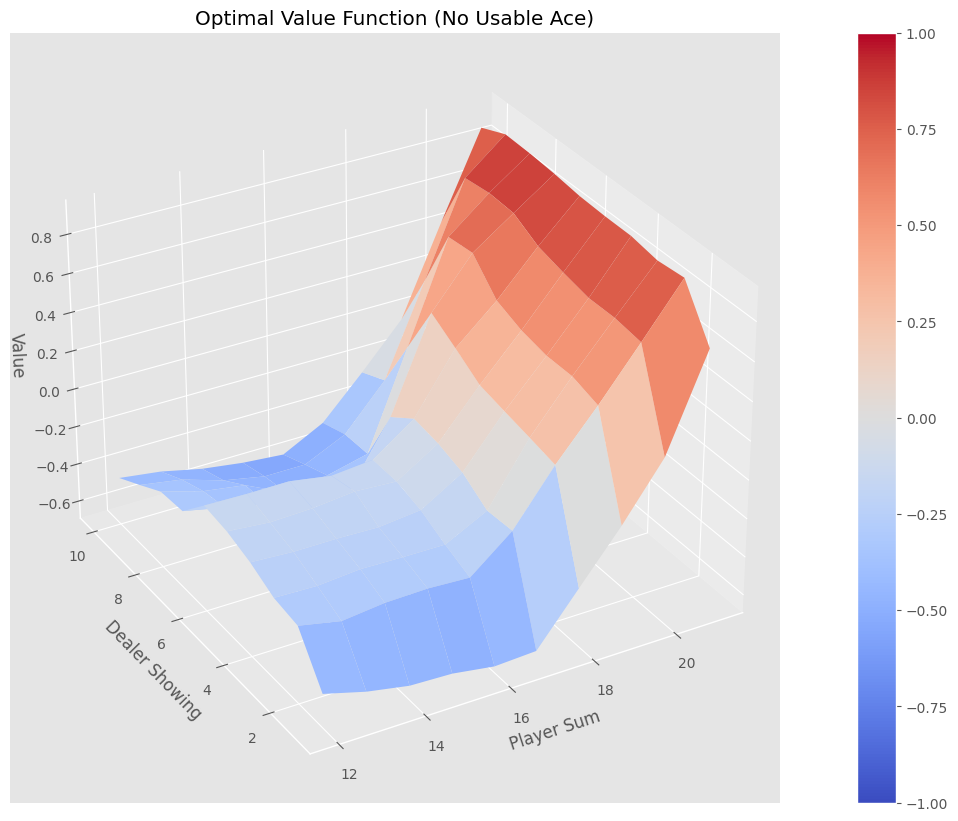

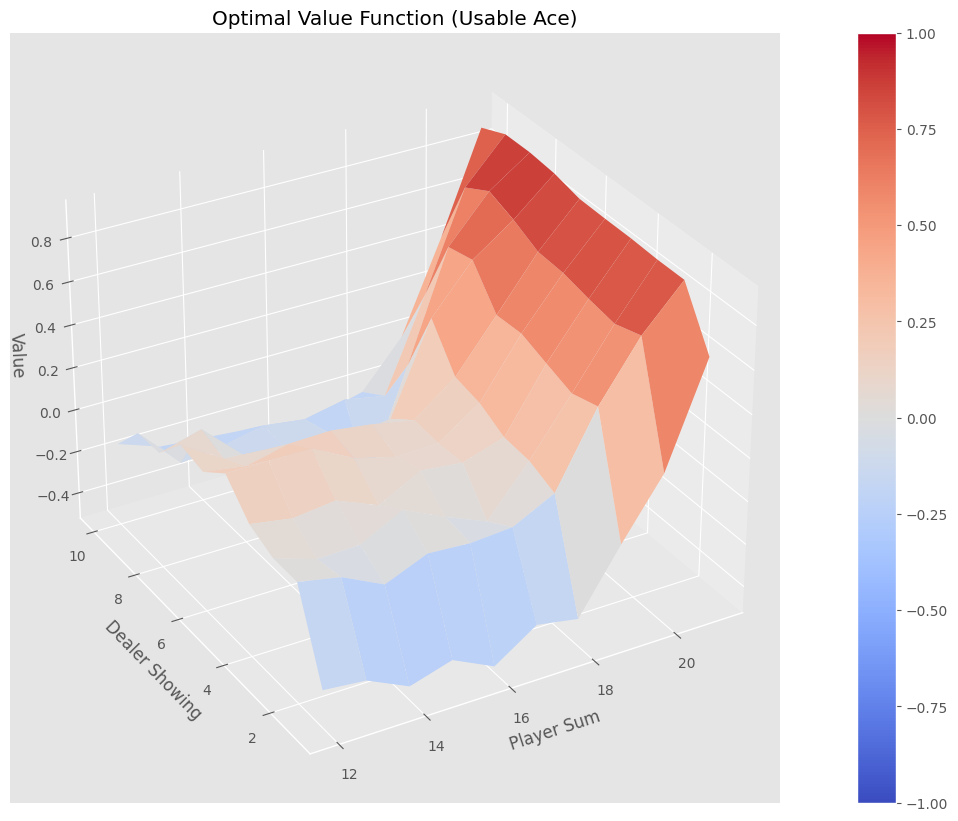

In [7]:
# 顯示最佳值函數的3D圖表，會產生兩個圖：
# 1.玩家手牌點數與莊家明牌對應的預期最大回報，無可用Ace時的值函數(Optimal Value Function (No Usable Ace))
# 2.有可用Ace時的值函數，展現較高的期望回報與不同策略價值(Optimal Value Function (Usable Ace))

# 初始化值函數V為defaultdict，預設值為0.0
V = defaultdict(float)

# 遍歷Q字典中每個狀態及其對應的動作價值陣列
for state, actions in Q.items():
    # 取得該狀態下所有動作的最大價值，代表最佳動作的價值
    action_value = np.max(actions)

    # 將最大動作價值存入值函數V對應狀態的位置
    V[state] = action_value

# 繪製值函數V的3D圖表，標題為"Optimal Value Function"
plotting.plot_value_function(V, title="Optimal Value Function")